In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab.patches import cv2_imshow

## LSB Removal

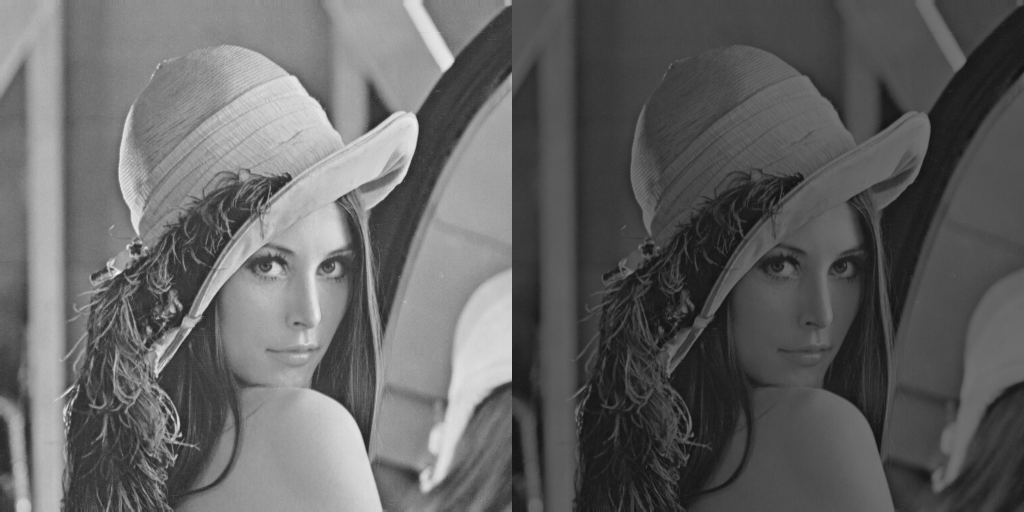

True

In [4]:
img=cv2.imread("/content/drive/MyDrive/DIP/Lenna.png",cv2.IMREAD_GRAYSCALE)
img=img.astype(int)
row,col=np.shape(img)
img2=np.zeros(shape=[row,col])

for i in range(row):
  for j in range(col):
    temp=img[i][j]  #retrieving pixel value
    tempbin=format(temp,'b')  #converting to binary string
    tempstr=""
    for k in range(len(tempbin),8): #converting all values to an 8 bit string by appending zeros at start
      tempstr+="0"
    tempbin=tempstr+tempbin #zero appending at beginning
    temp=tempbin[0:7] #taking only the first 7 bits
    temp=int(temp,2) #converts binary string to integer
    img2[i][j]=temp

result=np.hstack((img,img2))
cv2_imshow(result)
cv2.imwrite("/content/drive/MyDrive/DIP/7bit.png",result)

In [5]:
np.size(img),np.size(img2)

(262144, 262144)

## Separating each bit layer


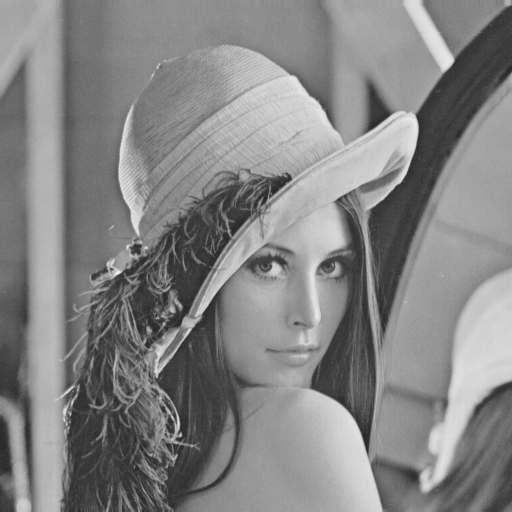

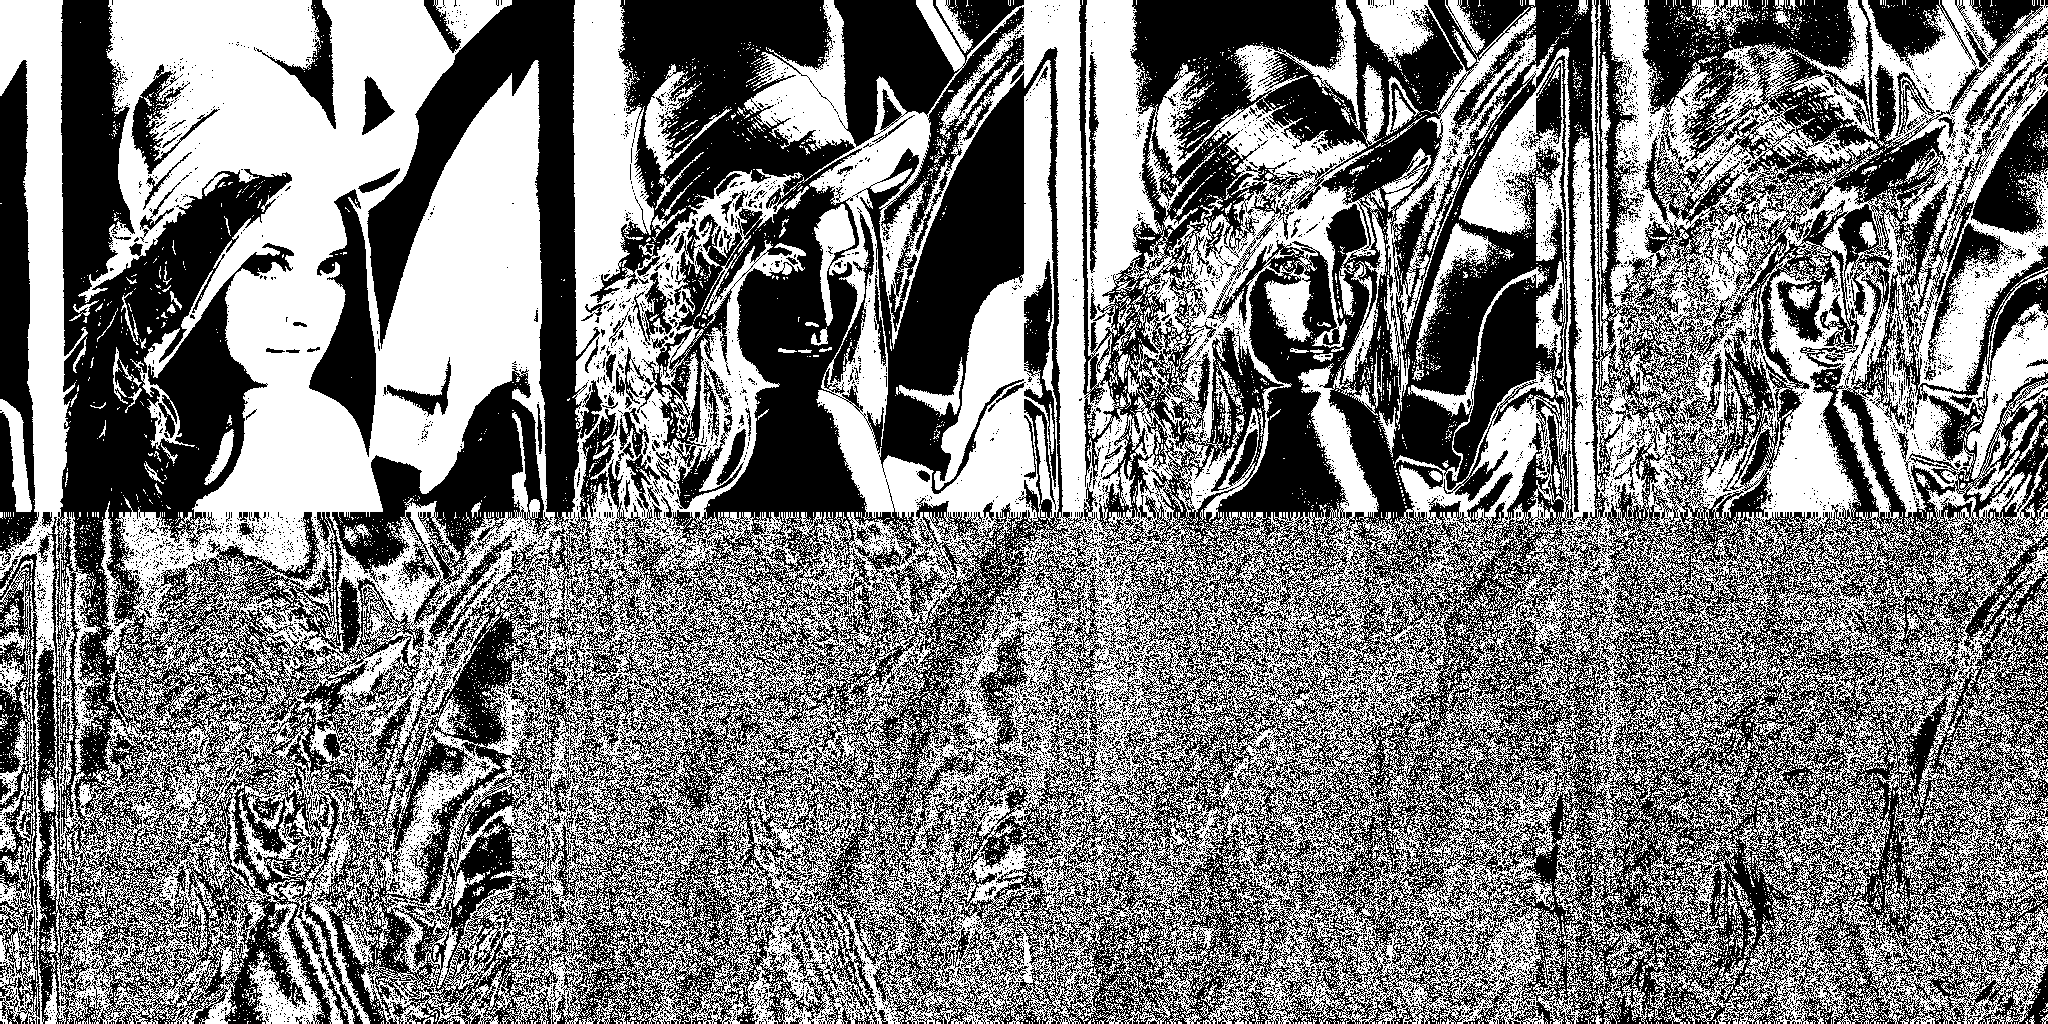

In [6]:
img=cv2.imread("/content/drive/MyDrive/DIP/Lenna.png",cv2.IMREAD_GRAYSCALE)
img=img.astype(int)
row,col=np.shape(img)
A7=np.zeros(shape=[row,col]) #MSB
A6=np.zeros(shape=[row,col])
A5=np.zeros(shape=[row,col])
A4=np.zeros(shape=[row,col])
A3=np.zeros(shape=[row,col])
A2=np.zeros(shape=[row,col])
A1=np.zeros(shape=[row,col])
A0=np.zeros(shape=[row,col])

def norm(n):
  if int(n)==0:
    return 0
  else:
    return 255

for i in range(row):
  for j in range(col):
    temp=img[i][j]
    temp=format(temp,'b')
    tempstr=""
    for k in range(len(temp),8):
      tempstr+="0"
    temp=tempstr+temp
    A7[i][j]=norm(temp[0])
    A6[i][j]=norm(temp[1])
    A5[i][j]=norm(temp[2])
    A4[i][j]=norm(temp[3])
    A3[i][j]=norm(temp[4])
    A2[i][j]=norm(temp[5])
    A1[i][j]=norm(temp[6])
    A0[i][j]=norm(temp[7])

temp=np.hstack((A7,A6,A5,A4))
temp2=np.hstack((A3,A2,A1,A0))
temp=np.vstack((temp,temp2))
cv2_imshow(img)
print()
cv2_imshow(temp)

## Adaptive Histogram Equalization

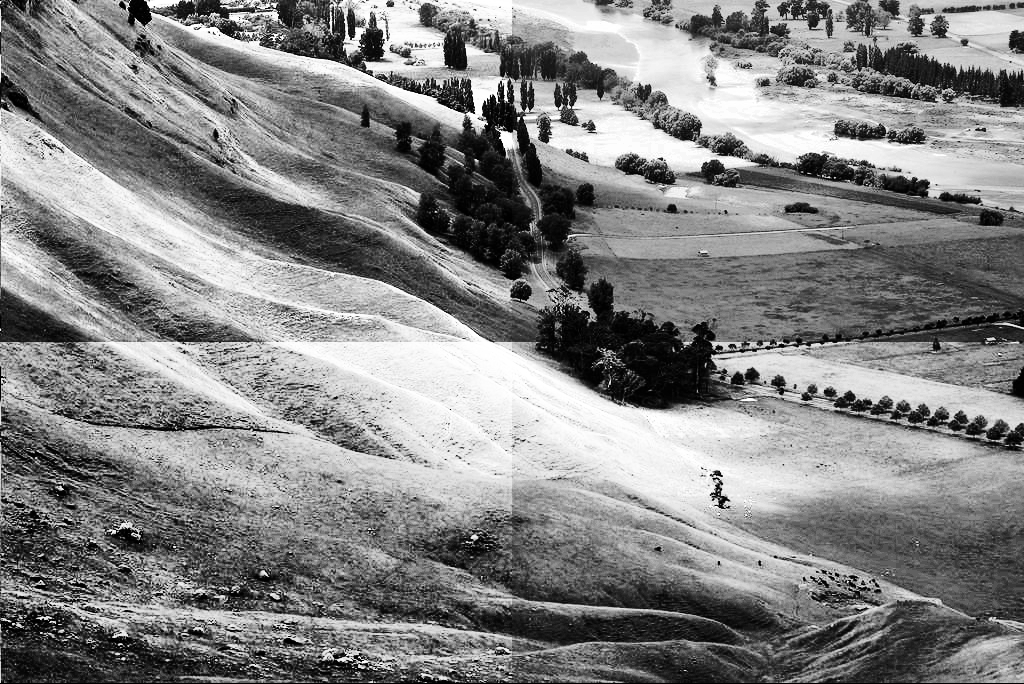

In [12]:
hawk=cv2.imread("/content/drive/MyDrive/DIP/hawk.jpg",cv2.IMREAD_GRAYSCALE)
hawk=hawk.astype(int)
hawkrow,hawkcol=np.shape(hawk)
hawk2=hawk
newcol=hawkcol%2
newrow=hawkrow%2
rowmat=[[]]
if newrow!=0:
  rowmat=np.zeros(shape=[1,hawkcol],dtype=int) #row matrix such that the elements are a list inside a list
  hawk2=np.append(hawk2,rowmat,axis=0)
if newcol!=0:
  colmat=np.zeros(shape=[1,hawkrow+newrow],dtype=int).reshape(hawkrow+newrow,1) #creating a column matrix such that the elements are a list inside a list
  #hawkrow+newrow used coz addition of an extra row creates one extra cell at the end of last column to be added
  hawk2=np.append(hawk2,colmat,axis=1)

tempr=int((hawkrow+newrow)/2)
tempc=int((hawkcol+newcol)/2)
temp=hawk2[0:tempr,0:tempc] #[:tempr][:tempc] wasnt working with the second part
temp=temp.astype(np.uint8)
temp1=cv2.equalizeHist(temp)
temp=hawk2[0:tempr,tempc:hawkcol+newcol]
temp=temp.astype(np.uint8)
temp2=cv2.equalizeHist(temp)
temp=hawk2[tempr:hawkrow+newrow,0:tempc]
temp=temp.astype(np.uint8)
temp3=cv2.equalizeHist(temp)
temp=hawk2[tempr:hawkrow+newrow,tempc:hawkcol+newcol]
temp=temp.astype(np.uint8)
temp4=cv2.equalizeHist(temp)
temp1=np.hstack((temp1,temp2))
temp3=np.hstack((temp3,temp4))
localizedhist=np.vstack((temp1,temp3))
cv2_imshow(localizedhist)

In [8]:
cv2.imwrite("/content/drive/MyDrive/DIP/localizedhistogram.png",localizedhist)

True

## Local Binary Pattern


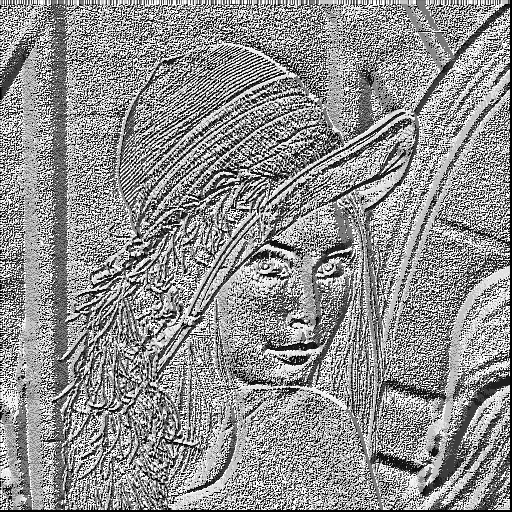

In [9]:
imgsrc=cv2.imread("/content/drive/MyDrive/DIP/Lenna.png",cv2.IMREAD_GRAYSCALE)
imgsrc=imgsrc.astype(int)
rowlbp,collbp=np.shape(imgsrc)
imglbp=np.zeros(shape=[rowlbp,collbp],dtype=int) #for storing empty values

#creating a border of empty pixels around the original image
temprow=np.zeros(shape=[1,collbp])
imgsrc=np.vstack((imgsrc,temprow)) #for vstack and hstack the arrays are to be passed as tuples
imgsrc=np.vstack((temprow,imgsrc))
tempcol=np.zeros([1,rowlbp+2]).reshape([rowlbp+2,1])
imgsrc=np.hstack((tempcol,imgsrc,tempcol))

"""
LBP Patterning----

if pixelvalue >= centervalue then it is set to 1, else 0
binary conversion begins from mid right pixel counter clockwise
                - - -
                - C *  asterisk mark corresponds to the LSB of binary value
                - - - 
"""

def compare(lst,centerval):
  for i in range(len(lst)):
    if (centerval>lst[i]):
      lst[i]=0
    else:
      lst[i]=1

  return lst

def binarypattern(centerval,row,col,imgsrc):
  binary=0
  temp=np.empty((8,),dtype=int)
  temp[7],temp[3]=imgsrc[row][col+1],imgsrc[row][col-1]
  temp[1],temp[5]=imgsrc[row+1][col],imgsrc[row-1][col]
  temp[0],temp[2]=imgsrc[row+1][col+1],imgsrc[row+1][col-1]
  temp[4],temp[6]=imgsrc[row-1][col-1],imgsrc[row-1][col+1]

  temp=compare(temp,centerval)

  temp=np.flip(temp)

  finalval=0
  for i in range(8):
    finalval+=(2**i)*temp[i]
  
  return finalval


for i in range(1,rowlbp-1):
  for j in range(1,collbp-1):
    imglbp[i-1][j-1]=binarypattern(imgsrc[i][j],i,j,imgsrc)

imglbp=imglbp.astype(np.uint8)
cv2_imshow(imglbp)

## Contrast Limited Adaptive Histogram Equalization (CLAHE)

preliminaries complete...
Clip Limit calculated...
Histogram manipulation begins...
...Histogram manipulation complete
Interpolation begins...
...Interpolation complete


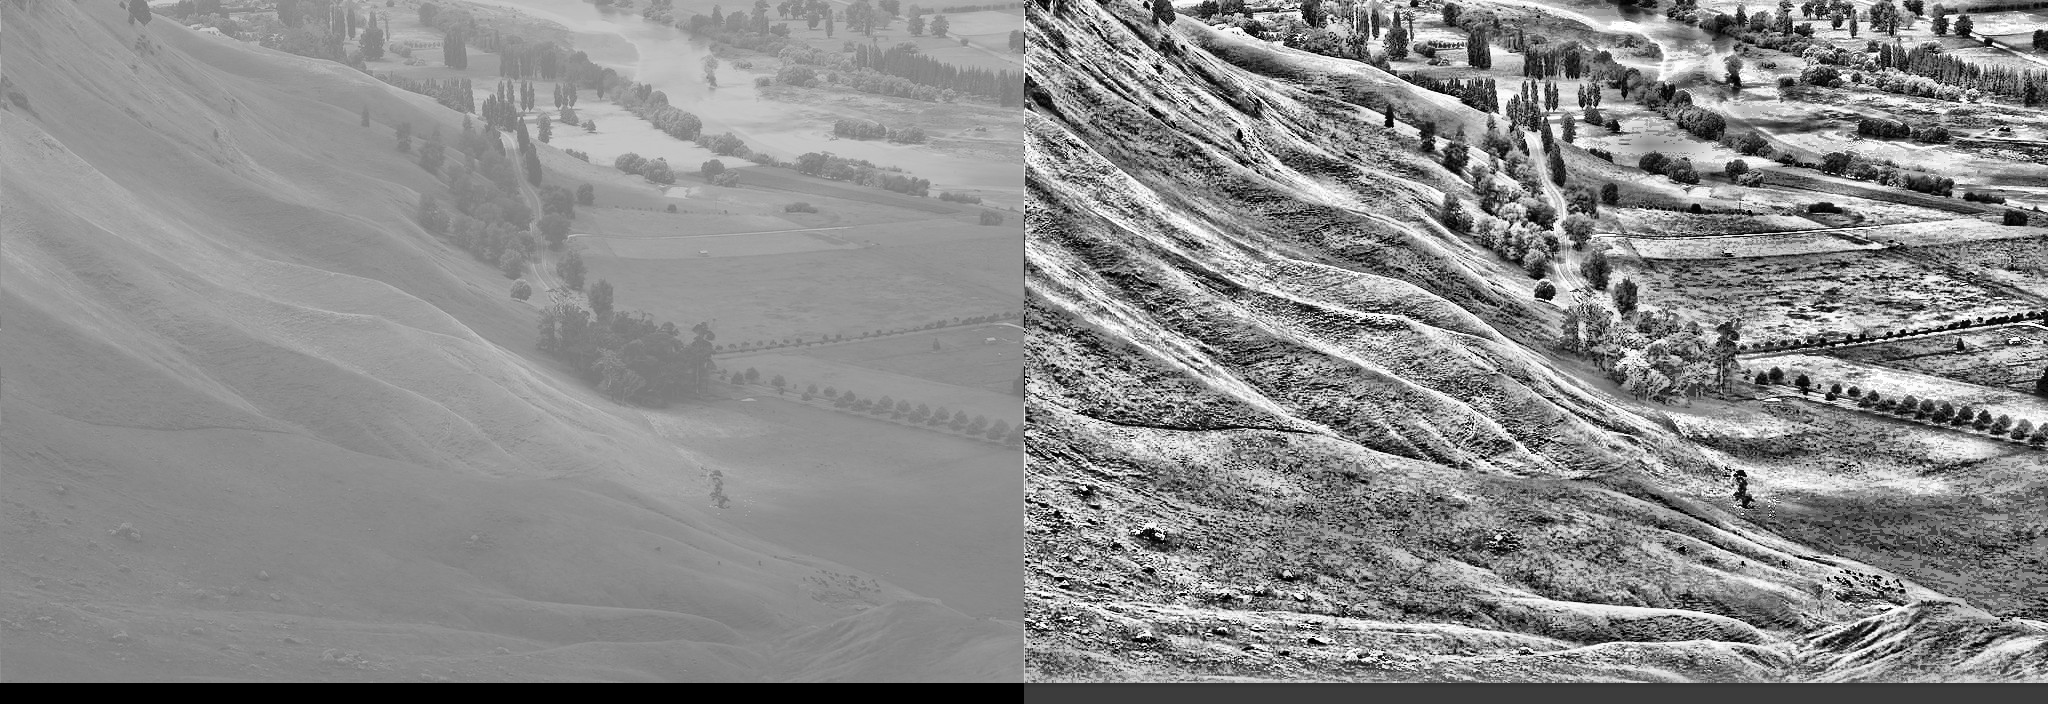

In [17]:
import numpy as np
import cv2
import matplotlib.pyplot as plt



def showImg(img):
    img=img.astype(np.uint8)
    cv2.imshow("window",img)
    cv2.waitKey()
    cv2.destroyAllWindows()
    cv2.waitKey(1)

#max contextual regions
MAX_REG_X=32
MAX_REG_Y=32

NrOfGrey=256 #max possible gray

def initializeClahe(img,const=0):
    #default size assumed to be 32*32 regions
    YRes,XRes=img.shape
    XSize,YSize=32,32
    extrarow=0 if YRes%YSize==0 else (YSize-(YRes%YSize))
    extracol=0 if XRes%XSize==0 else (XSize-(XRes%XSize))
    temprow=np.zeros((extrarow,XRes),dtype=int)
    img=np.vstack((img,temprow))
    img=img.astype(int)

    tempcol=np.zeros((YRes+extrarow,extracol),dtype=int)
    img=np.hstack((img,tempcol))

    YRes,XRes=np.shape(img)

    NrX,NrY=int(XRes/XSize),int(YRes/YSize)
    
    if const==0:
        return (img,YRes,XRes,NrY,NrX)
    elif const==1:
        return (NrY,NrX)
    else:
        print("wrong entry!")


def clahe(img,NrX=0,NrY=0,XSize=32,YSize=32,NrBins=128,XRes=0,YRes=0,Min=0,Max=255,clipLimit=30):

    global pulMapArray
    
    if (NrX>MAX_REG_X or NrY>MAX_REG_Y):
        print("too many contextual regions")

    if (Max>=NrOfGrey):
        print("too many grayscales")

    if (Min>=Max):
        print("min equal or greater than max !?")

    if ((NrX<=2 or NrY<=2) and (NrY!=0 or NrX!=0)):
        print("min 4 context. regions needed")

    if clipLimit==1:
        return

    if XRes==0 or YRes==0 or NrY==0 or NrX==0:
        (img,YRes,XRes,NrY,NrX)=initializeClahe(img,const=0)
    #each element contains map of that contextual region

    print("preliminaries complete...")


    NrPixels=int(XSize*YSize)

    if clipLimit>0:
        clipLimit=max(1,clipLimit*NrPixels/NrBins) #calculating actual clip limit
    else:
        clipLimit=10**8 #very large limit => no clipping only AHE

    print("Clip Limit calculated...")

    LUT=makeLUT(Min,Max,NrBins) #contains the mapped values onto NrBins values

    print("Histogram manipulation begins...")


    for iY in range(NrY):
        for iX in range(NrX):
            makeHistogram(img,pulMapArray,XSize,YSize,LUT,iY,iX)
            clipHistogram(pulMapArray,NrBins,clipLimit,iY,iX)
            mapHistogram(pulMapArray,Min,Max,NrBins,NrPixels,iY,iX)

    print("...Histogram manipulation complete")

    finalimg=np.zeros((img.shape))
    #temparr=np.zeros((NrY,NrX,6))

    print("Interpolation begins...")
    bins=LUT[img]


    claheimg=np.zeros(img.shape)

    xI = 0
    for i in range(NrY+1):
        if i==0:
            subX = int(YSize/2)
            xU = 0
            xB = 0
        elif i==NrY:
            subX = int(YSize/2)
            xU = NrY-1
            xB = NrY-1
        else:
            subX = YSize
            xU = i-1
            xB = i
        
        yI = 0
        for j in range(NrX+1):
            if j==0:
                subY = int(XSize/2)
                yL = 0
                yR = 0
            elif j==NrX:
                subY = int(XSize/2)
                yL = NrX-1
                yR = NrX-1
            else:
                subY = XSize
                yL = j-1
                yR = j
            UL = pulMapArray[xU,yL,:]
            UR = pulMapArray[xU,yR,:]
            BL = pulMapArray[xB,yL,:]
            BR = pulMapArray[xB,yR,:]
            #print("CLAHE vals...")
            subBin = bins[xI:xI+subX,yI:yI+subY]

            #print("clahe subBin shape: ",subBin.shape)

            #print("subBin shape size: ",subBin.shape[0],subBin.shape[1]) #tempppppp

            subImage = interpolate(subBin,UL,UR,BL,BR,subX,subY)

            #print("--> subImage shape size: ",subImage.shape[0],subImage.shape[1]) #ttemppp

            claheimg[xI:xI+subX,yI:yI+subY] = subImage
            yI += subY
        xI += subX
    print("...Interpolation complete")
    img=np.hstack((img,claheimg))
    return img

def makeHistogram(img,pulMapArray,XSize,YSize,LUT,iY,iX):

    subimg=img[iY*YSize:(iY+1)*YSize,iX*XSize:(iX+1)*XSize];
    for i in range(subimg.shape[0]):
        for j in range(subimg.shape[1]):
            temp=int(LUT[int(subimg[i][j])])
            
            pulMapArray[iY,iX,temp]+=1
    return pulMapArray


def clipHistogram(pulMapArray,NrBins,clipLimit,iY,iX):
    excess=0

    for i in range(NrBins):
        excess+=pulMapArray[iY,iX,i]-clipLimit if pulMapArray[iY,iX,i]>clipLimit else 0
        
        avgbinincr=int(excess/NrBins)
        upperlim=clipLimit-avgbinincr #bins upper than this are set to clipLimit

        for i in range(NrBins):
            if pulMapArray[iY,iX,i]>clipLimit:
                pulMapArray[iY,iX,i]=clipLimit
            else:
                if pulMapArray[iY,iX,i]>upperlim:
                    excess=excess-(pulMapArray[iY,iX,i]-upperlim) #doubtful point
                    pulMapArray[iY,iX,i]=clipLimit
                else:
                    excess=excess-avgbinincr
                    pulMapArray[iY,iX,i]+=avgbinincr

        tempcount=0
        #if excess remains
        while(excess):
            stepSize=int(NrBins/excess)
            tempcount+=1
            for i in range(0,NrBins,stepSize):
                if pulMapArray[iY,iX,i]<clipLimit:
                    pulMapArray[iY,iX,i]+=1
                    excess-=1
            if tempcount>50:
                break

def mapHistogram(pulMapArray,Min,Max,NrBins,NrPixels,iY,iX):
    Sum=0
    scale=(Max-Min)/NrPixels

    for i in range(NrBins):
        Sum+=pulMapArray[iY,iX,i]
        pulMapArray[iY,iX,i]=np.round(Min+Sum*scale)
        if pulMapArray[iY,iX,i]>Max:
            pulMapArray[iY,iX,i]=Max 

    return pulMapArray


def Interpolate(subBin,UL,UR,BL,BR,subX,subY,IY,IX):
    subImage = np.zeros(subBin.shape)
    num = subX*subY
    for i in range(subX):
        inverseI = subX-i
        for j in range(subY):
            inverseJ = subY-j
            
            val = subBin[i,j].astype(int)
            # except IndexError:
            # 	print("index error with subBin shape, subX, subY",subBin.shape,subX,subY," IY and IX respect: ",IY,IX)

            subImage[i,j] = np.floor((inverseI*(inverseJ*UL[val] + j*UR[val])+ i*(inverseJ*BL[val] + j*BR[val]))/num)
    return subImage

def makeLUT(Min,Max,NrBins):
    #for efficiency, [min,max] scaled down to [0,bins-1]
    binSize=int(1+(Max-Min)/NrBins) #not adding "int" gives errors
    lst=np.zeros((NrOfGrey,))

    for i in range(Min,Max+1):
        lst[i]=int((i-Min)/binSize)

    return lst

def interpolate(subBin,LU,RU,LB,RB,subX,subY):
    subImage = np.zeros(subBin.shape)
    num = subX*subY
    for i in range(subX):
        inverseI = subX-i
        for j in range(subY):
            inverseJ = subY-j
            val = subBin[i,j].astype(int)
            subImage[i,j] = np.floor((inverseI*(inverseJ*LU[val] + j*RU[val])+ i*(inverseJ*LB[val] + j*RB[val]))/num)
    return subImage



img=cv2.imread("/content/drive/MyDrive/DIP/hawk.jpg",cv2.IMREAD_GRAYSCALE)
img=img.astype(int)

NrBins=128 #assumed


(yy,xx)=initializeClahe(img,1)
pulMapArray=np.zeros((yy,xx,NrBins)) #declares array globally

img=clahe(img)

#showImg(img) ##does not work in colab
cv2_imshow(img)